# Lotka Volterra UPINN inverse

In [11]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [12]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 8 # Number of data points

time_int = [0, 20]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LotkaVolterraData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points)

td = data.td
Xd = data.Xd

In [13]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [14]:
# Collocation points
N_coll = 1000
Xc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [15]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']
        self.param_log = dict()

    def forward(self, z, U):

        sp = torch.nn.Softplus()

        if type(self.alpha) == torch.nn.parameter.Parameter: self.param_log.setdefault('alpha', []).append(sp(self.alpha).item())
        if type(self.beta) == torch.nn.parameter.Parameter: self.param_log.setdefault('beta', []).append(sp(self.beta).item()) 
        if type(self.delta) == torch.nn.parameter.Parameter: self.param_log.setdefault('delta', []).append(sp(self.delta).item())
        if type(self.gamma) == torch.nn.parameter.Parameter: self.param_log.setdefault('gamma', []).append(sp(self.gamma).item())

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - sp(self.alpha)*U[:, 0] + sp(self.beta)*U[:, 0]*U[:, 1],
            dUdt[:, 1] + sp(self.delta)*U[:, 1] - sp(self.gamma)*U[:, 0]*U[:, 1]
        ], dim=-1)


params = dict(
    alpha=torch.nn.Parameter(torch.tensor(0.0)),
    beta=torch.nn.Parameter(torch.tensor(0.0)),
    delta=torch.nn.Parameter(torch.tensor(0.0)),
    gamma=torch.nn.Parameter(torch.tensor(0.0))
)

N = SparseLV(params)

### Problem specific UPINN functions

In [16]:
class LV_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.nn.MSELoss()(u_pred, data.X_full)
    

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(t_plot)
            
            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig(save+'pdf', format='pdf', bbox_inches='tight')

            plt.show()

### Setup UPINN

In [17]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)

In [18]:
upinn = LV_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

In [19]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3, weight_decay=1e-4)
upinn.optimizer = adamw

for i in range(50):
    upinn.train_loop(epochs=1000)
    print(N.param_log['alpha'][-1], N.param_log['beta'][-1], N.param_log['delta'][-1], N.param_log['gamma'][-1])

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]:   0%|          | 0/1000 [00:00<?, ? epoch/s]

[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 76.12 epoch/s, bc_loss=2.07e-06, data_loss=9.68e-02, pde_loss=2.47e-03, loss=9.93e-02]


0.49225229024887085 0.9842067956924438 0.737819492816925 0.7159043550491333
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 76.28 epoch/s, bc_loss=2.41e-06, data_loss=8.94e-02, pde_loss=2.39e-03, loss=9.18e-02]


0.4905700087547302 1.003616213798523 0.8507734537124634 0.8345862627029419
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 75.81 epoch/s, bc_loss=3.50e-07, data_loss=4.99e-02, pde_loss=4.86e-03, loss=5.47e-02]


0.5067049264907837 1.076699137687683 0.90469890832901 0.8712167739868164
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 74.45 epoch/s, bc_loss=1.65e-06, data_loss=3.43e-02, pde_loss=3.76e-03, loss=3.80e-02]


0.5604290962219238 1.1501283645629883 0.980089545249939 0.9534149169921875
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 72.85 epoch/s, bc_loss=2.31e-07, data_loss=2.22e-02, pde_loss=3.48e-03, loss=2.57e-02]


0.5634979605674744 1.1395139694213867 1.022526502609253 0.9781010150909424
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 72.51 epoch/s, bc_loss=1.49e-06, data_loss=1.61e-03, pde_loss=1.64e-03, loss=3.25e-03]


0.5993723273277283 1.2363018989562988 0.9614996910095215 0.9394992589950562
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:14<00:00, 70.64 epoch/s, bc_loss=1.29e-05, data_loss=7.96e-04, pde_loss=1.83e-03, loss=2.63e-03]


0.6397076845169067 1.2890844345092773 0.9764143228530884 0.9671856164932251
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:14<00:00, 71.06 epoch/s, bc_loss=8.00e-07, data_loss=9.14e-04, pde_loss=1.86e-03, loss=2.78e-03]


0.6566025018692017 1.3134801387786865 0.9849759340286255 0.9790435433387756
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:14<00:00, 69.25 epoch/s, bc_loss=9.91e-09, data_loss=3.07e-05, pde_loss=2.56e-04, loss=2.86e-04]


0.661910355091095 1.3216526508331299 0.9886595010757446 0.983132004737854
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:14<00:00, 68.32 epoch/s, bc_loss=1.47e-06, data_loss=2.85e-04, pde_loss=7.51e-04, loss=1.04e-03]


0.6634414792060852 1.3244006633758545 0.9900436401367188 0.9845986366271973
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 65.04 epoch/s, bc_loss=1.01e-06, data_loss=3.95e-05, pde_loss=2.09e-04, loss=2.49e-04]


0.6641615629196167 1.3254947662353516 0.9909147620201111 0.9842324256896973
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 66.59 epoch/s, bc_loss=5.19e-09, data_loss=5.51e-06, pde_loss=1.42e-04, loss=1.48e-04]


0.6646213531494141 1.3275179862976074 0.9908844232559204 0.9858629703521729
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 65.68 epoch/s, bc_loss=9.09e-09, data_loss=6.35e-06, pde_loss=1.33e-04, loss=1.39e-04]


0.6648417115211487 1.3283331394195557 0.991628885269165 0.9868757128715515
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 66.23 epoch/s, bc_loss=2.32e-07, data_loss=4.55e-05, pde_loss=1.62e-04, loss=2.07e-04]


0.664405882358551 1.3268122673034668 0.991622805595398 0.9872212409973145
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 65.27 epoch/s, bc_loss=1.71e-05, data_loss=8.13e-04, pde_loss=8.55e-04, loss=1.68e-03]


0.6641302704811096 1.3270394802093506 0.9937911033630371 0.9894987344741821
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 64.47 epoch/s, bc_loss=1.55e-08, data_loss=3.65e-06, pde_loss=1.02e-04, loss=1.06e-04]


0.6635088324546814 1.3259588479995728 0.9949054718017578 0.9910005331039429
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 63.46 epoch/s, bc_loss=1.50e-08, data_loss=3.23e-06, pde_loss=9.45e-05, loss=9.77e-05]


0.6628135442733765 1.3247522115707397 0.9964919090270996 0.9928733110427856
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 63.11 epoch/s, bc_loss=1.32e-06, data_loss=2.39e-06, pde_loss=8.75e-05, loss=9.12e-05]


0.6623960733413696 1.3242168426513672 0.9976106286048889 0.9941677451133728
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 60.84 epoch/s, bc_loss=1.87e-06, data_loss=6.37e-05, pde_loss=1.08e-04, loss=1.73e-04]


0.6620161533355713 1.3237417936325073 0.998596727848053 0.995384693145752
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 60.56 epoch/s, bc_loss=1.96e-09, data_loss=2.20e-06, pde_loss=7.37e-05, loss=7.59e-05]


0.6615629196166992 1.3229858875274658 0.9996488690376282 0.9966758489608765
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 60.79 epoch/s, bc_loss=4.69e-07, data_loss=1.10e-05, pde_loss=7.32e-05, loss=8.47e-05]


0.6612632870674133 1.3225891590118408 1.0005253553390503 0.9977583885192871
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 61.08 epoch/s, bc_loss=9.31e-06, data_loss=1.57e-05, pde_loss=6.42e-05, loss=8.92e-05]


0.6608842015266418 1.3220558166503906 1.001528263092041 0.9984310865402222
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 60.55 epoch/s, bc_loss=8.05e-06, data_loss=2.63e-04, pde_loss=1.34e-04, loss=4.05e-04]


0.6604795455932617 1.3215382099151611 1.0029301643371582 0.9990769028663635
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:15<00:00, 62.96 epoch/s, bc_loss=1.26e-08, data_loss=1.41e-06, pde_loss=5.12e-05, loss=5.26e-05]


0.6601912975311279 1.3210351467132568 1.0032397508621216 1.0011948347091675
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 62.27 epoch/s, bc_loss=7.21e-06, data_loss=2.96e-06, pde_loss=4.91e-05, loss=5.92e-05]


0.6599212884902954 1.3206418752670288 1.0039753913879395 1.0021767616271973
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 61.77 epoch/s, bc_loss=8.07e-06, data_loss=3.02e-06, pde_loss=4.20e-05, loss=5.31e-05]


0.6597031950950623 1.3203941583633423 1.0045100450515747 1.0029356479644775
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 61.56 epoch/s, bc_loss=1.13e-04, data_loss=2.06e-05, pde_loss=4.23e-05, loss=1.76e-04]


0.6596270203590393 1.3204772472381592 1.005100965499878 1.0037081241607666
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 61.25 epoch/s, bc_loss=7.90e-09, data_loss=7.47e-07, pde_loss=3.53e-05, loss=3.61e-05]


0.6596139669418335 1.3206044435501099 1.0055452585220337 1.0042814016342163
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.59 epoch/s, bc_loss=6.43e-06, data_loss=3.27e-05, pde_loss=3.73e-05, loss=7.64e-05]


0.6596386432647705 1.3208016157150269 1.0057547092437744 1.0046162605285645
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.93 epoch/s, bc_loss=6.01e-07, data_loss=6.96e-07, pde_loss=2.97e-05, loss=3.10e-05]


0.6597219705581665 1.3210898637771606 1.006001591682434 1.0050623416900635
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.53 epoch/s, bc_loss=2.96e-08, data_loss=4.75e-07, pde_loss=2.65e-05, loss=2.70e-05]


0.6597812175750732 1.3213083744049072 1.0061395168304443 1.0053417682647705
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.63 epoch/s, bc_loss=1.21e-06, data_loss=8.29e-06, pde_loss=2.46e-05, loss=3.41e-05]


0.65993332862854 1.3215700387954712 1.0063492059707642 1.0056127309799194
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:17<00:00, 56.68 epoch/s, bc_loss=4.20e-08, data_loss=4.58e-07, pde_loss=2.16e-05, loss=2.21e-05]


0.6600202322006226 1.321958065032959 1.0064961910247803 1.0060086250305176
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:17<00:00, 55.78 epoch/s, bc_loss=1.12e-07, data_loss=4.65e-06, pde_loss=2.58e-05, loss=3.06e-05]


0.6600726842880249 1.3220834732055664 1.0066742897033691 1.0063658952713013
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:21<00:00, 47.48 epoch/s, bc_loss=3.09e-05, data_loss=1.03e-04, pde_loss=3.76e-05, loss=1.72e-04]


0.6602616906166077 1.322511911392212 1.0067713260650635 1.006675124168396
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:20<00:00, 48.86 epoch/s, bc_loss=2.45e-06, data_loss=2.00e-06, pde_loss=1.53e-05, loss=1.98e-05]


0.6603851318359375 1.3228576183319092 1.0066136121749878 1.0064826011657715
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:20<00:00, 49.72 epoch/s, bc_loss=3.74e-06, data_loss=5.74e-05, pde_loss=1.69e-05, loss=7.81e-05]


0.6607768535614014 1.3235208988189697 1.0068742036819458 1.0065721273422241
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:19<00:00, 50.57 epoch/s, bc_loss=1.06e-05, data_loss=1.59e-04, pde_loss=3.36e-05, loss=2.03e-04]


0.6611471176147461 1.324157953262329 1.0065646171569824 1.0067293643951416
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:18<00:00, 52.89 epoch/s, bc_loss=3.88e-06, data_loss=1.75e-06, pde_loss=1.03e-05, loss=1.59e-05]


0.6614685654640198 1.3250114917755127 1.0060313940048218 1.0061910152435303
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:21<00:00, 47.60 epoch/s, bc_loss=7.17e-07, data_loss=1.31e-04, pde_loss=1.36e-05, loss=1.45e-04]


0.6619063019752502 1.3257882595062256 1.0058079957962036 1.0059642791748047
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:22<00:00, 44.62 epoch/s, bc_loss=4.14e-06, data_loss=1.03e-04, pde_loss=1.37e-05, loss=1.21e-04]


0.6623097062110901 1.3264657258987427 1.0053541660308838 1.0055092573165894
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:19<00:00, 50.27 epoch/s, bc_loss=4.20e-08, data_loss=2.37e-07, pde_loss=7.43e-06, loss=7.71e-06]


0.6627615690231323 1.3273341655731201 1.0046255588531494 1.0049779415130615
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:20<00:00, 49.54 epoch/s, bc_loss=1.92e-08, data_loss=4.78e-07, pde_loss=6.78e-06, loss=7.27e-06]


0.6631572842597961 1.328054666519165 1.0044901371002197 1.0048797130584717
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:21<00:00, 46.99 epoch/s, bc_loss=4.81e-07, data_loss=1.11e-05, pde_loss=6.42e-06, loss=1.80e-05]


0.6635074019432068 1.3286941051483154 1.0038676261901855 1.0043147802352905
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:21<00:00, 46.35 epoch/s, bc_loss=3.35e-06, data_loss=2.89e-05, pde_loss=8.88e-06, loss=4.11e-05]


0.6638669371604919 1.329270601272583 1.0035088062286377 1.0038224458694458
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:20<00:00, 48.00 epoch/s, bc_loss=1.44e-05, data_loss=5.00e-05, pde_loss=2.56e-05, loss=9.00e-05]


0.6640661954879761 1.3298836946487427 1.0034605264663696 1.003286361694336
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:23<00:00, 43.35 epoch/s, bc_loss=3.87e-06, data_loss=5.90e-05, pde_loss=6.38e-06, loss=6.92e-05]


0.6643401384353638 1.3302557468414307 1.0028870105743408 1.003148078918457
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:24<00:00, 41.52 epoch/s, bc_loss=5.64e-07, data_loss=1.36e-06, pde_loss=5.75e-06, loss=7.67e-06]


0.6644425988197327 1.330581545829773 1.0025609731674194 1.002727746963501
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:26<00:00, 37.55 epoch/s, bc_loss=1.80e-06, data_loss=9.07e-06, pde_loss=4.87e-06, loss=1.57e-05]


0.6647101640701294 1.330939769744873 1.0024724006652832 1.002590537071228
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:22<00:00, 44.19 epoch/s, bc_loss=2.36e-06, data_loss=1.81e-05, pde_loss=1.23e-05, loss=3.27e-05]

0.66490638256073 1.3312281370162964 1.002058506011963 1.0024363994598389


In [21]:
upinn.load('lv_pinn_inverse', 'models')

In [23]:
u_pred = upinn.u(data.t_full)
RRMSE = torch.sqrt(torch.nn.MSELoss()(u_pred, data.X_full)) / torch.sqrt(torch.mean(data.X_full**2))
print('RRMSE:', RRMSE.item())

RRMSE: 0.004245880525559187


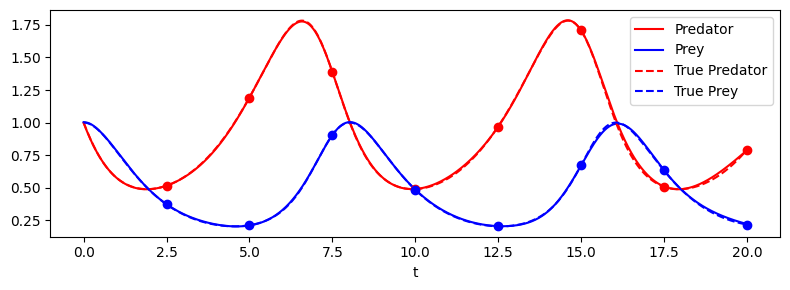

In [28]:
upinn.to('cpu')

plt.figure( figsize=(8, 3) )

u_pred = upinn.u(data.t_full)

plt.plot(data.t_full, u_pred[:, 0].detach().numpy(), 'r', label='Predator')
plt.plot(data.t_full, u_pred[:, 1].detach().numpy(), 'b', label='Prey')
plt.plot(data.t_full, data.X_full[:, 0].detach().numpy(), 'r--', label='True Predator')
plt.plot(data.t_full, data.X_full[:, 1].detach().numpy(), 'b--', label='True Prey')
plt.plot(data.td, data.Xd[:, 0], 'ro')
plt.plot(data.td, data.Xd[:, 1], 'bo')

plt.xlabel('t')
plt.legend()
plt.tight_layout()
plt.savefig('gfx/lv-pinn-inverse.pdf', format='pdf', bbox_inches='tight')
plt.show()

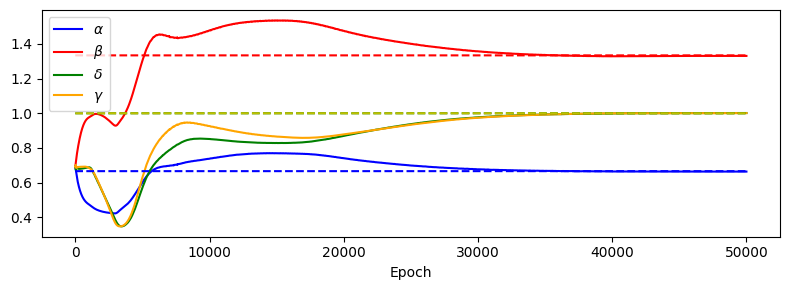

In [31]:
plt.figure( figsize=(8, 3) )

plt.plot(N.param_log['alpha'], label=r'$\alpha$', color='blue')
plt.plot(N.param_log['beta'], label=r'$\beta$', color='red')
plt.plot(N.param_log['delta'], label=r'$\delta$', color='green')
plt.plot(N.param_log['gamma'], label=r'$\gamma$', color='orange')

plt.plot([alpha]*len(N.param_log['alpha']), 'b--')
plt.plot([beta]*len(N.param_log['beta']), 'r--')
plt.plot([delta]*len(N.param_log['delta']), 'g--')
plt.plot([gamma]*len(N.param_log['gamma']), 'y--')

plt.legend()
plt.xlabel('Epoch')

plt.tight_layout()
plt.savefig('gfx/lv-pinn-inverse-params.pdf', format='pdf', bbox_inches='tight')
plt.show()